In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
sc = spark.SparkContext()
sql = spark.SQLContext(sc)
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from elephas.utils.rdd_utils import to_simple_rdd

Using TensorFlow backend.


## Single Feature Sentiment Analysis

In [16]:
df = pd.read_csv('Data/bitcoin_hourly_price_sent.csv')
df.head()

,date,open,open_volume,close,close_volume,high,low,subjectivity_overall,polarity_overall,vader_compound_overall,...,polarity_aggregated,vader_compound_aggregated,vader_pos_aggregated,vader_neg_aggregated,vader_neu_aggregated,afinn_score_aggregated,effective_polarity_aggregated,effective_afinn_aggregated,effective_vader_aggregated,agg_sentiment_polarity_aggregated
0,2021-02-05 10:00:00,37280.0,5.716755,37435.0,0.459237,37666.0,37219.21804,0.174242,0.131818,0.281118,...,0.131818,0.281118,0.128000,0.000000,0.872000,1.454545,0.272727,0.272727,0.545455,0.545455
1,2021-02-05 11:00:00,37437.0,1.474718,37729.0,0.429433,37741.0,37437.00000,0.297378,0.094089,0.132855,...,0.094089,0.132855,0.087602,0.034909,0.877455,0.556818,0.306818,0.306818,0.340909,0.397727
2,2021-02-05 12:00:00,37723.0,0.798632,37957.0,7.263832,38195.0,37576.00000,0.295138,0.114819,0.182863,...,0.114819,0.182863,0.098058,0.024576,0.877367,0.899281,0.323741,0.323741,0.359712,0.453237
3,2021-02-05 13:00:00,37939.0,2.709258,38355.0,2.241080,38366.0,37870.00000,0.299525,0.112090,0.136151,...,0.112090,0.136151,0.083718,0.024511,0.891771,0.603053,0.267176,0.267176,0.251908,0.328244
4,2021-02-05 14:00:00,38354.0,8.743720,38128.0,0.602789,38366.0,38022.00000,0.297600,0.124420,0.139875,...,0.124420,0.139875,0.075038,0.021925,0.903031,0.643750,0.387500,0.387500,0.306250,0.462500


In [17]:
df = df[['date','close','agg_sentiment_polarity_aggregated']]
df.columns=['DateTime','Price','Sentiment_score']

Plotting the input variables

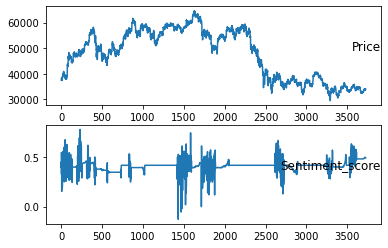

In [18]:
values = df.values
# specify columns to plot
groups = [1, 2]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

Set index to datetime and change the order of columns

In [19]:
df.set_index('DateTime',inplace=True)  
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df


,Sentiment_score,Price
DateTime,,
2021-02-05 10:00:00,0.545455,37435.000000
2021-02-05 11:00:00,0.397727,37729.000000
2021-02-05 12:00:00,0.453237,37957.000000
2021-02-05 13:00:00,0.328244,38355.000000
2021-02-05 14:00:00,0.462500,38128.000000
...,...,...
2021-07-10 12:00:00,0.498507,33843.000000
2021-07-10 13:00:00,0.496322,33670.000000
2021-07-10 14:00:00,0.496397,33801.000000


In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

In [21]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [22]:
n_hours = 3  #no of time lags
n_features = 1 #no of features
n_obs = n_hours*n_features

In [23]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
3,0.738498,0.227358,0.576828,0.235726,0.637577,0.242216,0.500787,0.253544
4,0.576828,0.235726,0.637577,0.242216,0.500787,0.253544,0.647714,0.247083
5,0.637577,0.242216,0.500787,0.253544,0.647714,0.247083,0.310494,0.241931
6,0.500787,0.253544,0.647714,0.247083,0.310494,0.241931,0.511188,0.238058
7,0.647714,0.247083,0.310494,0.241931,0.511188,0.238058,0.648564,0.239796


In [24]:
reframed = reframed.drop(reframed.columns[-1], axis=1)
reframed.head()

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
3,0.738498,0.227358,0.576828,0.235726,0.637577,0.242216,0.500787
4,0.576828,0.235726,0.637577,0.242216,0.500787,0.253544,0.647714
5,0.637577,0.242216,0.500787,0.253544,0.647714,0.247083,0.310494
6,0.500787,0.253544,0.647714,0.247083,0.310494,0.241931,0.511188
7,0.647714,0.247083,0.310494,0.241931,0.511188,0.238058,0.648564


In [28]:
values = reframed.values
n_train_hours = 3000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(3000, 7)

In [29]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [30]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3000, 3, 1) (3000,) (722, 3, 1) (722,)


In [31]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history


Train on 3000 samples, validate on 722 samples
Epoch 1/30
 - 2s - loss: 0.1081 - val_loss: 0.0300
Epoch 2/30
 - 1s - loss: 0.0317 - val_loss: 0.0296
Epoch 3/30
 - 1s - loss: 0.0317 - val_loss: 0.0289
Epoch 4/30
 - 1s - loss: 0.0319 - val_loss: 0.0293
Epoch 5/30
 - 1s - loss: 0.0319 - val_loss: 0.0317
Epoch 6/30
 - 1s - loss: 0.0314 - val_loss: 0.0295
Epoch 7/30
 - 1s - loss: 0.0317 - val_loss: 0.0358
Epoch 8/30
 - 1s - loss: 0.0315 - val_loss: 0.0361
Epoch 9/30
 - 1s - loss: 0.0316 - val_loss: 0.0380
Epoch 10/30
 - 1s - loss: 0.0314 - val_loss: 0.0383
Epoch 11/30
 - 1s - loss: 0.0315 - val_loss: 0.0392
Epoch 12/30
 - 1s - loss: 0.0313 - val_loss: 0.0383
Epoch 13/30
 - 1s - loss: 0.0310 - val_loss: 0.0387
Epoch 14/30
 - 1s - loss: 0.0312 - val_loss: 0.0407
Epoch 15/30
 - 1s - loss: 0.0313 - val_loss: 0.0412
Epoch 16/30
 - 1s - loss: 0.0312 - val_loss: 0.0412
Epoch 17/30
 - 1s - loss: 0.0311 - val_loss: 0.0397
Epoch 18/30
 - 1s - loss: 0.0313 - val_loss: 0.0414
Epoch 19/30
 - 1s - loss: 

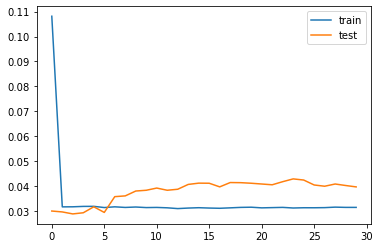

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [33]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.051


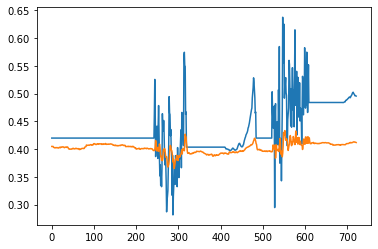

In [34]:
plt.plot(inv_y)
plt.plot(inv_yhat)

In [35]:
plt.show()

In [36]:
inv_y = np.insert(inv_y,0,7000)

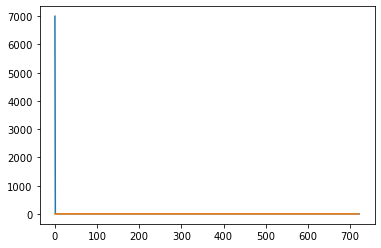

In [37]:
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

# Elephas Implementation

In [40]:
df=df.reset_index()
spark_df = sql.createDataFrame(df)
CleanDF = spark_df.withColumn("DateTime_casted",spark_df['DateTime'].cast(TimestampType()))
FinalDf = CleanDF.selectExpr("DateTime_casted as Date_Time", "Sentiment_score",'Price AS Price1')

In [41]:
#from keras.engine.training import _slice_arrays

ImportError: cannot import name '_slice_arrays' from 'keras.engine.training' (/opt/conda/lib/python3.7/site-packages/keras/engine/training.py)

In [43]:
FinalDf.show()

+-------------------+-------------------+------------------+
|          Date_Time|    Sentiment_score|            Price1|
+-------------------+-------------------+------------------+
|2021-02-05 10:00:00| 0.5454545454545454|           37435.0|
|2021-02-05 11:00:00| 0.3977272727272727|           37729.0|
|2021-02-05 12:00:00| 0.4532374100719425|           37957.0|
|2021-02-05 13:00:00| 0.3282442748091603|           38355.0|
|2021-02-05 14:00:00|             0.4625|           38128.0|
|2021-02-05 15:00:00|0.15436241610738255|           37947.0|
|2021-02-05 16:00:00| 0.3377483443708609|    37810.93317996|
|2021-02-05 17:00:00| 0.4632768361581921|           37872.0|
|2021-02-05 18:00:00|0.34328358208955223|           37371.0|
|2021-02-05 19:00:00| 0.3834586466165413|37604.044422000006|
|2021-02-05 20:00:00|0.20175438596491227|           37732.0|
|2021-02-05 21:00:00|               0.24|           37811.0|
|2021-02-05 22:00:00| 0.3009708737864077|           37782.0|
|2021-02-05 23:00:00|0.2

In [44]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window
for i in range(2,3):
    col1 = "Price%d"%(i-1)
    col2 = "Price%d"%i
    w = Window().partitionBy().orderBy(col("Date_Time"))
    FinalDf=FinalDf.select("*", lag(col1).over(w).alias(col2)).na.drop()
    FinalDf.show()

+-------------------+-------------------+------------------+------------------+
|          Date_Time|    Sentiment_score|            Price1|            Price2|
+-------------------+-------------------+------------------+------------------+
|2021-02-05 11:00:00| 0.3977272727272727|           37729.0|           37435.0|
|2021-02-05 12:00:00| 0.4532374100719425|           37957.0|           37729.0|
|2021-02-05 13:00:00| 0.3282442748091603|           38355.0|           37957.0|
|2021-02-05 14:00:00|             0.4625|           38128.0|           38355.0|
|2021-02-05 15:00:00|0.15436241610738255|           37947.0|           38128.0|
|2021-02-05 16:00:00| 0.3377483443708609|    37810.93317996|           37947.0|
|2021-02-05 17:00:00| 0.4632768361581921|           37872.0|    37810.93317996|
|2021-02-05 18:00:00|0.34328358208955223|           37371.0|           37872.0|
|2021-02-05 19:00:00| 0.3834586466165413|37604.044422000006|           37371.0|
|2021-02-05 20:00:00|0.20175438596491227

In [45]:
FinalDf = FinalDf.selectExpr('Date_Time','Sentiment_score','Price2 as Input_price','Price1 as Price')

In [46]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

In [47]:
rdd = to_simple_rdd(sc, train_X, train_y)

In [48]:
rdd.count()

3000

In [49]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
#from keras.models import model_from_yaml,slice_X


In [50]:
from keras.utils import np_utils
from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd
from elephas import optimizers as elephas_optimizers

ImportError: cannot import name 'optimizers' from 'elephas' (/opt/conda/lib/python3.7/site-packages/elephas/__init__.py)

In [51]:
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [52]:
adam = elephas_optimizers.Adam()

NameError: name 'elephas_optimizers' is not defined

In [1]:
spark_model = SparkModel(sc,model, optimizer=adam, frequency='epoch', num_workers=2)
spark_model.train(rdd, nb_epoch=50, batch_size=4, verbose=2, validation_split=0.1)

## Multifeature Sentiment Analysis

In [53]:
df1 = pd.read_csv('Data/bitcoin_hourly_price_sent.csv')
df1=df1[['date','vader_neg_overall','vader_neu_overall','vader_pos_overall','vader_compound_overall','close']]
df1.columns = ['DateTime','Negative','Neutral','Positive','Compound','Price']
df1.head()

,DateTime,Negative,Neutral,Positive,Compound,Price
0,2021-02-05 10:00:00,0.000000,0.872000,0.128000,0.281118,37435.0
1,2021-02-05 11:00:00,0.034909,0.877455,0.087602,0.132855,37729.0
2,2021-02-05 12:00:00,0.024576,0.877367,0.098058,0.182863,37957.0
3,2021-02-05 13:00:00,0.024511,0.891771,0.083718,0.136151,38355.0
4,2021-02-05 14:00:00,0.021925,0.903031,0.075038,0.139875,38128.0


In [54]:
df1 = pd.read_csv('Data/bitcoin_hourly_price_sent.csv')
df1=df1[['date','vader_neg_overall','vader_neu_overall','vader_pos_overall','vader_compound_overall','close']]

In [55]:
df1.columns

Index(['date', 'vader_neg_overall', 'vader_neu_overall', 'vader_pos_overall',
       'vader_compound_overall', 'close'],
      dtype='object')

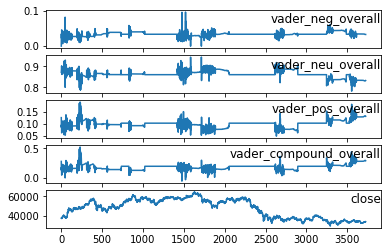

In [56]:
values = df1.values
# specify columns to plot
groups = [1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df1.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [58]:
df1.set_index('date',inplace=True)

In [59]:
cols = df1.columns.tolist()
cols = cols[-1:] + cols[:-1]
df1 = df1[cols]
df1.head()

,close,vader_neg_overall,vader_neu_overall,vader_pos_overall,vader_compound_overall
date,,,,,
2021-02-05 10:00:00,37435.0,0.000000,0.872000,0.128000,0.281118
2021-02-05 11:00:00,37729.0,0.034909,0.877455,0.087602,0.132855
2021-02-05 12:00:00,37957.0,0.024576,0.877367,0.098058,0.182863
2021-02-05 13:00:00,38355.0,0.024511,0.891771,0.083718,0.136151
2021-02-05 14:00:00,38128.0,0.021925,0.903031,0.075038,0.139875


In [60]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df1.values)

In [61]:
n_hours = 3
n_features = 5
n_obs = n_hours*n_features

In [62]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.227358,0.000000,0.550507,0.542544,0.578338,0.235726,0.358928,0.584093,0.257428,0.320214,0.242216,0.252680,0.583553,0.331218,0.407277,0.253544,0.252021,0.672245,0.230011,0.325953
4,0.235726,0.358928,0.584093,0.257428,0.320214,0.242216,0.252680,0.583553,0.331218,0.407277,0.253544,0.252021,0.672245,0.230011,0.325953,0.247083,0.225428,0.741580,0.168750,0.332437
5,0.242216,0.252680,0.583553,0.331218,0.407277,0.253544,0.252021,0.672245,0.230011,0.325953,0.247083,0.225428,0.741580,0.168750,0.332437,0.241931,0.476964,0.655927,0.094118,0.175911
6,0.253544,0.252021,0.672245,0.230011,0.325953,0.247083,0.225428,0.741580,0.168750,0.332437,0.241931,0.476964,0.655927,0.094118,0.175911,0.238058,0.293678,0.596790,0.287858,0.354919
7,0.247083,0.225428,0.741580,0.168750,0.332437,0.241931,0.476964,0.655927,0.094118,0.175911,0.238058,0.293678,0.596790,0.287858,0.354919,0.239796,0.281384,0.564909,0.332806,0.382013


In [63]:
reframed = reframed.drop(reframed.columns[-4:], axis=1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
3,0.227358,0.000000,0.550507,0.542544,0.578338,0.235726,0.358928,0.584093,0.257428,0.320214,0.242216,0.252680,0.583553,0.331218,0.407277,0.253544
4,0.235726,0.358928,0.584093,0.257428,0.320214,0.242216,0.252680,0.583553,0.331218,0.407277,0.253544,0.252021,0.672245,0.230011,0.325953,0.247083
5,0.242216,0.252680,0.583553,0.331218,0.407277,0.253544,0.252021,0.672245,0.230011,0.325953,0.247083,0.225428,0.741580,0.168750,0.332437,0.241931
6,0.253544,0.252021,0.672245,0.230011,0.325953,0.247083,0.225428,0.741580,0.168750,0.332437,0.241931,0.476964,0.655927,0.094118,0.175911,0.238058
7,0.247083,0.225428,0.741580,0.168750,0.332437,0.241931,0.476964,0.655927,0.094118,0.175911,0.238058,0.293678,0.596790,0.287858,0.354919,0.239796


In [64]:
values = reframed.values
n_train_hours = 3000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(3000, 16)

In [65]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [66]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3000, 3, 5) (3000,) (722, 3, 5) (722,)


In [67]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Train on 3000 samples, validate on 722 samples
Epoch 1/20
 - 2s - loss: 0.0430 - val_loss: 0.0491
Epoch 2/20
 - 1s - loss: 0.0309 - val_loss: 0.0443
Epoch 3/20
 - 1s - loss: 0.0267 - val_loss: 0.0413
Epoch 4/20
 - 1s - loss: 0.0249 - val_loss: 0.0392
Epoch 5/20
 - 1s - loss: 0.0231 - val_loss: 0.0370
Epoch 6/20
 - 1s - loss: 0.0214 - val_loss: 0.0352
Epoch 7/20
 - 1s - loss: 0.0197 - val_loss: 0.0335
Epoch 8/20
 - 1s - loss: 0.0179 - val_loss: 0.0333
Epoch 9/20
 - 1s - loss: 0.0155 - val_loss: 0.0297
Epoch 10/20
 - 1s - loss: 0.0141 - val_loss: 0.0240
Epoch 11/20
 - 1s - loss: 0.0127 - val_loss: 0.0206
Epoch 12/20
 - 1s - loss: 0.0106 - val_loss: 0.0175
Epoch 13/20
 - 1s - loss: 0.0073 - val_loss: 0.0143
Epoch 14/20
 - 1s - loss: 0.0059 - val_loss: 0.0117
Epoch 15/20
 - 1s - loss: 0.0053 - val_loss: 0.0109
Epoch 16/20
 - 1s - loss: 0.0052 - val_loss: 0.0112
Epoch 17/20
 - 1s - loss: 0.0050 - val_loss: 0.0113
Epoch 18/20
 - 1s - loss: 0.0045 - val_loss: 0.0091
Epoch 19/20
 - 1s - loss: 

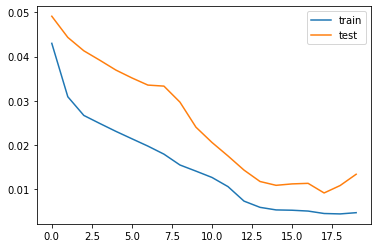

In [68]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [69]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 618.573


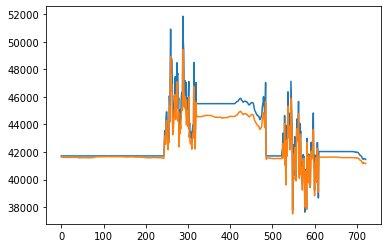

In [70]:
plt.plot(inv_y)
plt.plot(inv_yhat)

In [71]:
plt.show()

In [72]:
inv_yhat.shape

(722,)

In [73]:
df_sol = pd.DataFrame({'forecast':inv_yhat,'actual':inv_y})
df_sol.to_csv('Predictions_nosent.csv')